In [1]:
import numpy as np
import matplotlib.pyplot as plt

import water_tank as wt
from tqdm.notebook import tqdm_notebook

In [2]:
class Miconi(object):

    dt = 1.0 # Discretization step in ms
    ID_OUTPUT = 0 # Output neuron

    def __init__(self, 
                 N_in:int, 
                 N:int, 
                 g:float, 
                 tau:float, 
                 sparseness:float, 
                 perturbation_frequency:float=3.,
                 perturbation_amplitude:float=16.,
                 alpha_mean:float=0.05,
                 learning_rate:float=0.5,
                 clip_dW:float=0.0003,
                ):

        self.N_in = N_in
        self.N = N
        self.g = g
        self.tau = tau
        self.sparseness = sparseness
        self.perturbation_frequency=perturbation_frequency
        self.perturbation_amplitude=perturbation_amplitude
        self.alpha_mean = alpha_mean

        # Input population
        self.inp = wt.StaticInput(size=self.N_in)

        # Reservoir 
        self.rc = wt.MiconiLayer(
            size=self.N, 
            tau=self.tau,
            perturbation_frequency=perturbation_frequency,
            perturbation_amplitude=perturbation_amplitude,
            alpha_mean = alpha_mean,
        )

        # Input projection
        self.inp_proj = wt.connect(
            pre = self.inp, 
            post = self.rc, 
            weights = wt.Uniform(-1.0, 1.0), 
            bias = None,
            sparseness = 0.1
        )

        # Recurrent projection
        self.rec_proj = wt.connect(
            pre = self.rc, 
            post = self.rc, 
            weights = wt.Normal(0.0, self.g/np.sqrt(self.sparseness*self.N)), 
            #bias = wt.Bernouilli([-1.0, 1.0], p=0.5),
            sparseness = self.sparseness,
        )

        # Learning rules
        self.learningrule = wt.MiconiLearningRule(
            projection=self.rec_proj,
            learning_rate=learning_rate,
            clip_dW=clip_dW,
        )

        # Recorder
        self.recorder = wt.Recorder()

    def trial(self, 
              X:np.ndarray, 
              target:float, 
              critic:float=None,
              response_duration:int=200, 
              training:bool=True,
              record:bool=True,
              ):

        T, _ = X.shape

        # Perturbation
        if training:
            perturbations = np.random.geometric(
                    self.perturbation_frequency/1000., (T, self.N)
                ) == 1
        
        # Init
        self.rc.init()

        # Oterate over time steps
        responses = []
        for t, x in enumerate(X): 

            # Inputs/targets
            self.inp.set(x)

            # Steps 
            self.rc.step(perturbation=perturbations[t, :] if training else None) 
            if training: self.learningrule.step()

            # Record output neuron
            if t > T - response_duration:
                responses.append(self.rc.r[self.ID_OUTPUT])

            # Recording
            if record:
                self.recorder.record({
                    'rc': self.rc.output(), 
                })
        
        # Learning at the end of the trial
        response = np.mean(responses)
        reward = - np.abs(target - response)
        if training: self.learningrule.train(reward=reward, critic=critic)

        return reward

In [3]:
net = Miconi(
    N_in=2, 
    N=200, 
    g=1.5, 
    tau=10.0, 
    sparseness=1.0,
    perturbation_frequency=3.,
    perturbation_amplitude=16.,
    alpha_mean=0.05,
    learning_rate=0.5,
    clip_dW=0.0003,
)

/Users/vitay/.virtualenvs/reservoirpy/lib/python3.11/site-packages/scipy/sparse/_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [4]:
AA = np.zeros((1200, 2))
AA[200:400, 0] = 1.0
AA[600:800, 0] = 1.0

AB = np.zeros((1200, 2))
AB[200:400, 0] = 1.0
AB[600:800, 1] = 1.0

BA = np.zeros((1200, 2))
BA[200:400, 1] = 1.0
BA[600:800, 0] = 1.0

BB = np.zeros((1200, 2))
BB[200:400, 1] = 1.0
BB[600:800, 1] = 1.0

In [5]:
## AA
reward = net.trial(X=AA, target=-0.98, training=False)
init_AA = net.recorder.get()

## AB
reward = net.trial(X=AB, target=0.98, training=False)
init_AB = net.recorder.get()

## BA
reward = net.trial(X=BA, target=0.98, training=False)
init_BA = net.recorder.get()

## BB
reward = net.trial(X=BB, target=-0.98, training=False)
init_BB = net.recorder.get()

In [6]:
rewards = []

critic = {
    'AA': -1.0,
    'AB': -1.0,
    'BA': -1.0,
    'BB': -1.0,
}

for epoch in (t := tqdm_notebook(range(1000))):
    ## AA
    reward_AA = net.trial(X=AA, target=-0.98, critic=critic['AA'], record=False)
    critic['AA'] = 0.75 * critic['AA'] + 0.25 * reward_AA

    ## AB
    reward_AB = net.trial(X=AB, target=0.98, critic=critic['AB'], record=False)
    critic['AB'] = 0.75 * critic['AB'] + 0.25 * reward_AB

    ## BA
    reward_BA = net.trial(X=BA, target=0.98, critic=critic['BA'], record=False)
    critic['BA'] = 0.75 * critic['BA'] + 0.25 * reward_BA

    ## BB
    reward_BB = net.trial(X=BB, target=-0.98, critic=critic['BB'], record=False)
    critic['BB'] = 0.75 * critic['BB'] + 0.25 * reward_BB

    rws = [reward_AA, reward_AB, reward_BA, reward_BB]
    rewards.append(rws)
    t.set_description(f'AA: {reward_AA:.2f} AB: {reward_AB:.2f} BA: {reward_BA:.2f} BB: {reward_BB:.2f}')

  0%|          | 0/1000 [00:00<?, ?it/s]

In [7]:
## AA
reward = net.trial(X=AA, target=-0.98, training=False)
final_AA = net.recorder.get()

## AB
reward = net.trial(X=AB, target=0.98, training=False)
final_AB = net.recorder.get()

## BA
reward = net.trial(X=BA, target=0.98, training=False)
final_BA = net.recorder.get()

## BB
reward = net.trial(X=BB, target=-0.98, training=False)
final_BB = net.recorder.get()

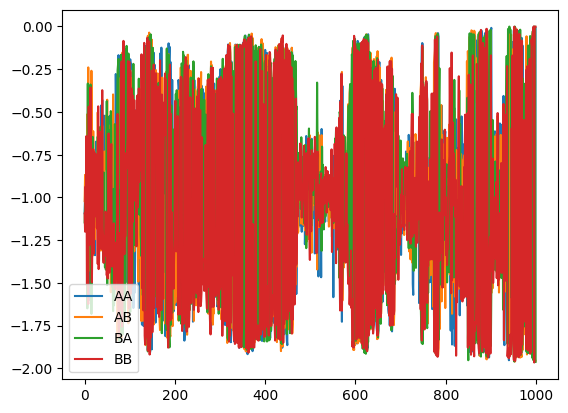

In [8]:
rewards = np.array(rewards)
plt.plot(rewards[:, 0], label='AA')
plt.plot(rewards[:, 1], label='AB')
plt.plot(rewards[:, 2], label='BA')
plt.plot(rewards[:, 3], label='BB')
plt.legend()

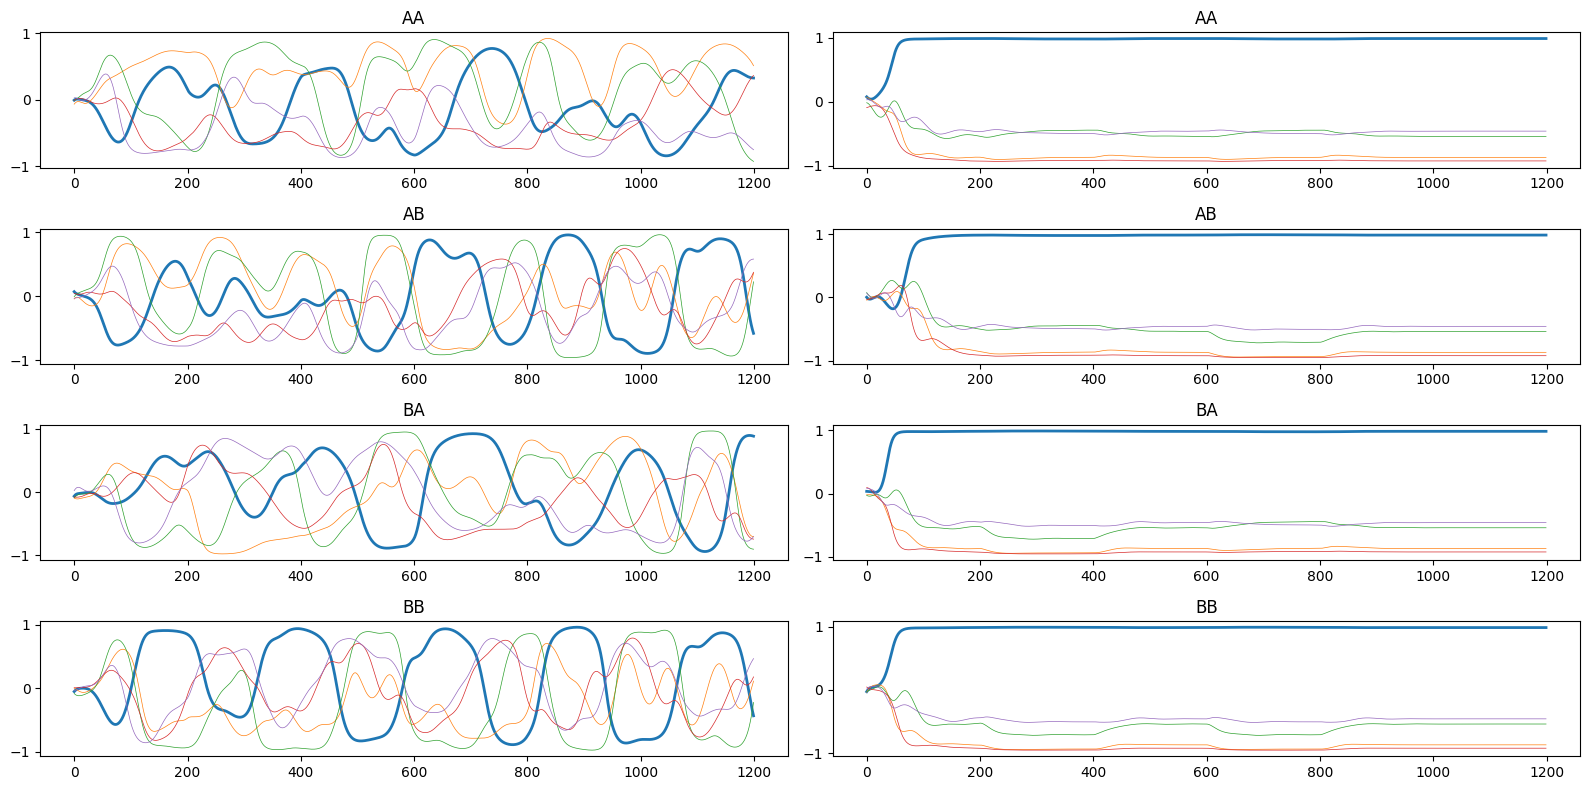

In [9]:
plt.figure(figsize=(16, 8))

plt.subplot(421)
plt.title("AA")
for i in range(5):
    plt.plot(init_AA['rc'][:, i], lw=2 if i==0 else .5)

plt.subplot(422)
plt.title("AA")
for i in range(5):
    plt.plot(final_AA['rc'][:, i], lw=2 if i==0 else .5)

plt.subplot(423)
plt.title("AB")
for i in range(5):
    plt.plot(init_AB['rc'][:, i], lw=2 if i==0 else .5)

plt.subplot(424)
plt.title("AB")
for i in range(5):
    plt.plot(final_AB['rc'][:, i], lw=2 if i==0 else .5)

plt.subplot(425)
plt.title("BA")
for i in range(5):
    plt.plot(init_BA['rc'][:, i], lw=2 if i==0 else .5)

plt.subplot(426)
plt.title("BA")
for i in range(5):
    plt.plot(final_BA['rc'][:, i], lw=2 if i==0 else .5)

plt.subplot(427)
plt.title("BB")
for i in range(5):
    plt.plot(init_BB['rc'][:, i], lw=2 if i==0 else .5)

plt.subplot(428)
plt.title("BB")
for i in range(5):
    plt.plot(final_BB['rc'][:, i], lw=2 if i==0 else .5)

plt.tight_layout()